# A

In [1]:
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
all_data=pd.read_csv("./raw_data/all_data.csv")
validaiton=pd.read_csv("./raw_data/Validation_McPAS.csv")
validaiton['vdjdb_score']='Nan'
validaiton = validaiton.reindex(all_data.columns, axis=1)
all_data = pd.concat([validaiton, all_data], ignore_index=True)
all_data['database']=all_data['database'].replace('vdjdb', 'VDJdb')
data=all_data[(all_data['CDR3B_length'].between(10, 18)) & (all_data['Epitope_length'] == 9)]
epitope_counts = data['Epitope'].value_counts()
data.loc[:, 'Epitope_Count'] = data['Epitope'].map(epitope_counts)
data = data.sort_values('Epitope')
data = data[data['Epitope_Count'] >= 50]

/tmp/ipykernel_79739/1636964168.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'Epitope_Count'] = data['Epitope'].map(epitope_counts)


In [2]:
replacement_dict = {'SARS-CoV2': 'SARS-CoV-2', 
                    'Hepatitis C virus': 'HCV',
                 'Influenza A virus':'Influenza'   ,
                 'Human herpesvirus 4 (Epstein Barr virus)':'EBV'   ,
                 'InfluenzaA':'Influenza'   ,
                  'Epstein Barr virus (EBV)':  'EBV' ,
                   'SARS-CoV1': 'SARS-CoV-1' ,
                   'Human immunodeficiency virus (HIV)':'HIV'  ,
                  'HIV-1':'HIV' ,
                    'FLU' :'Influenza',
                     'Cytomegalovirus (CMV)':'CMV',
                   'Human herpesvirus 5 (Human cytomegalovirus)':'CMV',
                   'Human T-cell leukemia virus type I (Human T cell leukemia virus type 1)':'HTLV-1',
                   'Neoantigen' :'unknown',
                    'Yellow fever virus (Flavivirus febricis)':'YFV',
                    'Yellow fever virus' :'YFV',
                    'nan':'unknown',
                    'HomoSapiens':'unknown',
                     'SARS coronavirus Tor2 (Severe acute respiratory syndrome-related coronavirus Tor2)': 'SARS-CoV-2',
                  'HTLV-1 (Chronic':'HTLV-1',
                   'Homo sapiens (human)':'unknown',
                   'Diabetes Type 1':'Diabetes'}
data['antigen_species'] = data['antigen_species'].replace(replacement_dict)
data.loc[data['antigen_species'].isnull(), 'antigen_species'] = 'unknown'

In [3]:
data.to_csv("./raw_data/train_data_fix_antigen.csv")
antigen=pd.unique(data['antigen_species'])
species_list = ['SARS-CoV-2', 'SARS-CoV-1', 'EBV', 'HCV', 'Influenza', 'HIV',
                'CMV', 'HTLV-1', 'unknown', 'YFV', 'glioblastoma',
                'Diabetes']
antigen = pd.DataFrame({'antigen_species': species_list})

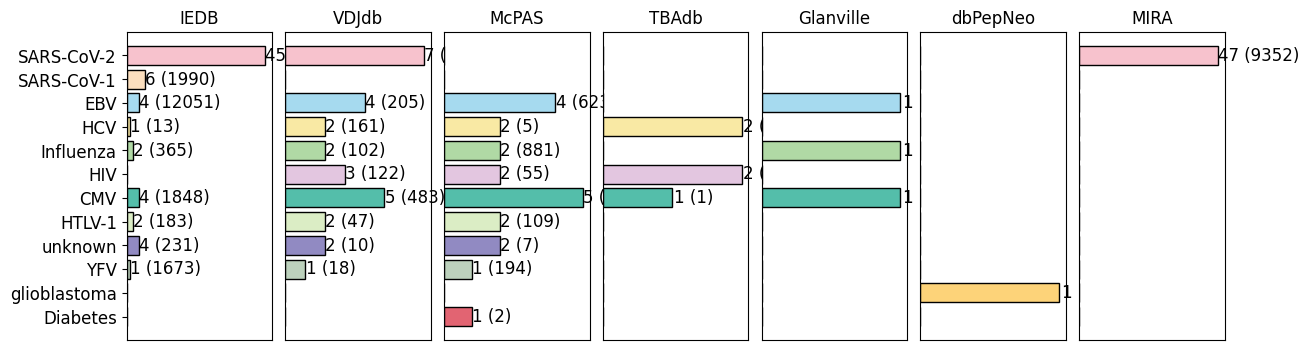

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['xtick.labelsize'] = 12  
plt.rcParams['ytick.labelsize'] = 12  
colors=['#E26472','#FDD379','#BCD1BC','#918AC2','#DBEDC5','#54beaa','#E3C6E0',
        '#B0D9A5','#F9E9A4','#A6DAEF','#FCDFBE','#F7C2CD','#CECCE5','#A6519E']

def create_bar_plot(ax, data, title, colors, show_yaxis=False):
    bars = ax.barh(data['antigen_species'], data['Epitope_Type_Count'], color=colors, edgecolor='black')
    for bar, cdr3b_count in zip(bars, data['CDR3B_Type_Count']):
        if bar.get_width() > 0:  
            label = f"{bar.get_width()} ({cdr3b_count})"
            ax.annotate(label, (bar.get_width() + 0.02, bar.get_y() + bar.get_height() / 2),
                        ha='left', va='center', fontsize=12)
    ax.set_xlabel('Epitope Type Count')
    ax.get_xaxis().set_visible(False)
    if show_yaxis:
        ax.get_yaxis().set_visible(True)  
    else:
        ax.get_yaxis().set_visible(False) 
    ax.set_title(title)

databases = ['IEDB', 'VDJdb', 'McPAS', 'TBAdb', 'Glanville', 'dbPepNeo', 'MIRA']
fig, axes = plt.subplots(nrows=1, ncols=len(databases), figsize=(14, 4))
for i, (ax, db) in enumerate(zip(axes, databases)):
    pos = ax.get_position()
    new_pos = [pos.x0 + i * 0, pos.y0, pos.width *1.1, pos.height]  
    ax.set_position(new_pos)
    
    db_data = data[data['database'] == db]
    epitope_types = db_data.groupby('antigen_species')['Epitope'].nunique()
    cdr3b_types = db_data.groupby('antigen_species')['CDR3B'].nunique()
    count_df = pd.DataFrame({
        'Epitope_Type_Count': epitope_types,
        'CDR3B_Type_Count': cdr3b_types
    }).reset_index()
    count_df = antigen.merge(count_df, on='antigen_species', how='left').fillna(0)
    count_df['Epitope_Type_Count'] = count_df['Epitope_Type_Count'].astype(int)
    count_df['CDR3B_Type_Count'] = count_df['CDR3B_Type_Count'].astype(int)
    count_df = count_df.iloc[::-1].reset_index(drop=True)
    show_yaxis = (i == 0)  
    create_bar_plot(ax, count_df, db, colors, show_yaxis)

path = "./All_results/fig/fig3/"
plt.savefig(path + 'A_all_data_antigen_and_TCR.pdf', bbox_inches='tight')
plt.show()


# B

In [2]:
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data=pd.read_csv("./raw_data/epitope_morethan_50.csv")
data['database']=data['database'].replace('vdjdb', 'VDJdb')
data = data[['Epitope', 'antigen_species']]
import pandas as pd
replacement_dict = {
    'SARS-CoV2': 'SARS-CoV-2',
    'Hepatitis C virus': 'HCV',
    'HIV-1': 'HCV',
    'InfluenzaA': 'Influenza',
    'Influenza A virus': 'Influenza',
    'Human herpesvirus 4 (Epstein Barr virus)': 'EBV',
    'SARS-CoV1': 'SARS-CoV-1',
    'HIV-1': 'HIV-1',
    'Human immunodeficiency virus (HIV)': 'HIV',
    'FLU': 'Influenza',
    'Human herpesvirus 5 (Human cytomegalovirus)': 'CMV',
    'Human T-cell leukemia virus type I (Human T cell leukemia virus type 1)': 'HTLV-1',
    'Yellow fever virus (Flavivirus febricis)': 'YFV',
    'HomoSapiens': 'Unknown',
    'SARS coronavirus Tor2 (Severe acute respiratory syndrome-related coronavirus Tor2)': 'SARS-CoV-2',
    'glioblastoma': 'Glioblastoma',
    'Homo sapiens (human)': 'Unknown'}

data['antigen_species'] = data['antigen_species'].replace(replacement_dict)
data['antigen_species'] = data['antigen_species'].fillna('Unknown')
pd.unique(data['antigen_species'])


array(['SARS-CoV-2', 'HCV', 'Influenza', 'EBV', 'SARS-CoV-1', 'HIV-1',
       'HIV', 'CMV', 'HTLV-1', 'YFV', 'Unknown', 'Glioblastoma'],
      dtype=object)

/tmp/ipykernel_4820/2724435545.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_data.loc[:, 'species_count'] = unique_data['antigen_species'].map(species_unique_counts)


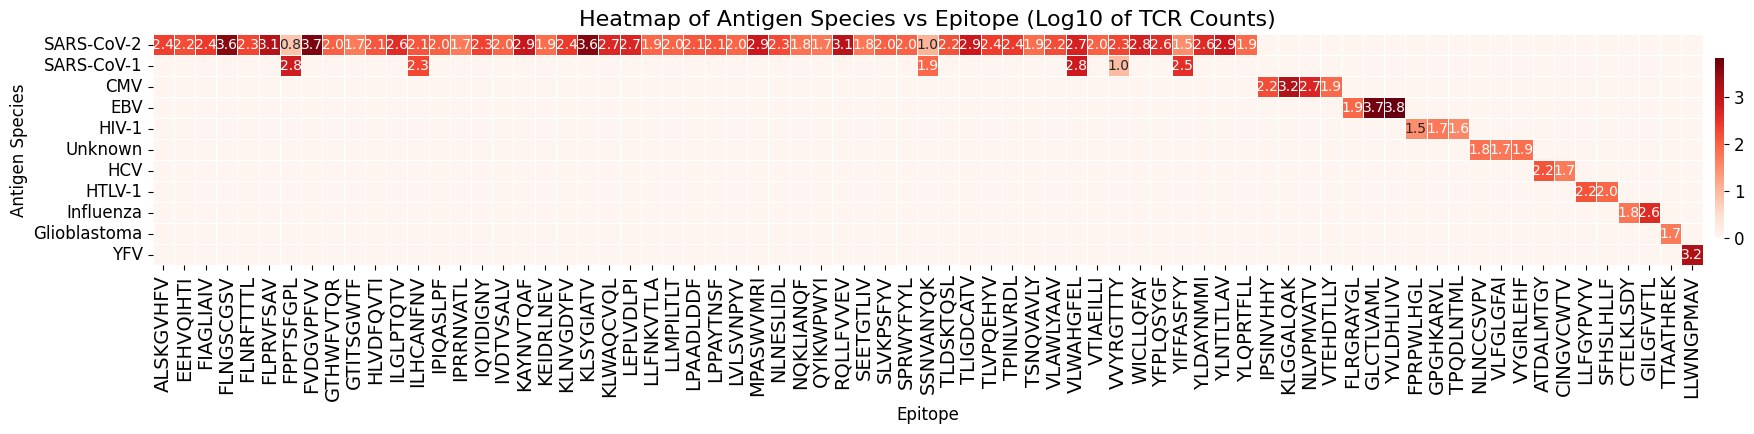

In [17]:
from matplotlib.colors import LinearSegmentedColormap
unique_data = data.drop_duplicates(subset=['Epitope', 'antigen_species'])
species_unique_counts = unique_data.groupby('antigen_species')['Epitope'].nunique()
unique_data.loc[:, 'species_count'] = unique_data['antigen_species'].map(species_unique_counts)
sorted_df = unique_data.sort_values(by=['species_count', 'antigen_species', 'Epitope'], ascending=[False, True, True])
sorted_df = sorted_df.drop(columns=['species_count'])
sorted_df = sorted_df.reset_index(drop=True)
epi_sorted=sorted_df.drop_duplicates(subset=['Epitope'], keep='first')
epitope_order = epi_sorted['Epitope'].tolist()
count_df = data.groupby(['antigen_species', 'Epitope']).size().unstack(fill_value=0)
sorted_df = count_df.reindex(columns=epitope_order)
row_order = pd.unique(epi_sorted['antigen_species'])
position = np.where(row_order == 'SARS-CoV-2')[0][0]
row_order = np.insert(row_order, position + 1, 'SARS-CoV-1')
sorted_df = sorted_df.reindex(row_order)
sorted_df.to_csv('./All_results/data/data2/B_train_test_data.csv')
count_df_log = np.log10(sorted_df + 1)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['xtick.labelsize'] = 14 
plt.rcParams['ytick.labelsize'] = 12  
plt.figure(figsize=(25, 3))
annot_matrix = np.where(count_df_log > 0, count_df_log.round(1).astype(str), '')
colors = ["#f0f8ff", "#f0dc82", "#004225"]  
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
sns.heatmap(count_df_log, cmap='Reds', linewidths=.5, annot=annot_matrix, fmt="s", cbar_kws={'shrink': 0.5})
plt.title("Heatmap of Antigen Species vs Epitope (Log10 of TCR Counts)", fontsize=16)
plt.xlabel("Epitope", fontsize=12)
plt.ylabel("Antigen Species", fontsize=12)
cbar = plt.gcf().axes[-1]
cbar.set_position([0.75, 0.2, 0.02, 0.6]) 
cbar.set_label('Log10(TCR Count)')
cbar.yaxis.label.set_size(12)  
cbar.yaxis.labelpad = 10      

path = "./All_results/fig/fig3/"
plt.savefig(path + 'B_epitope_and_TCR_train_data.pdf', bbox_inches='tight')
plt.show()

# C

In [10]:
import pandas as pd
import os


def process_results(path_suffix):
    name = ['1', '2', '3', '4', '5']
    merged_dict = {}
    for i in name:
        dataframes = {
            'ERGO_lstm': pd.read_csv(f"./ERGO/result/pair50/seen/{path_suffix}/{i}_1_1lstm_all_result.csv"),
            'ERGO_AE': pd.read_csv(f"./ERGO/result/pair50/seen/{path_suffix}/{i}_1_1ae_all_result.csv"),
            'NetTCR': pd.read_csv(f"./NetTCR/result/pair50/seen/{path_suffix}/{i}_1_1all_result.csv"),
            'DLpTCR_CNN': pd.read_csv(f"./DLpTCR/result/pair50/seen/{path_suffix}/{i}_1_1CNN_pca20_all_result.csv"),
            'DLpTCR_FULL': pd.read_csv(f"./DLpTCR/result/pair50/seen/{path_suffix}/{i}_1_1FULL_pca18_all_result.csv"),
            'DLpTCR_RESNET': pd.read_csv(f"./DLpTCR/result/pair50/seen/{path_suffix}/{i}_1_1RESNET_pca10_all_result.csv"),
            'AttnTAP': pd.read_csv(f"./AttnTAP/result/pair50/seen/{path_suffix}/{i}_1_1all_result.csv"),
            'ATM_TCR': pd.read_csv(f"./ATM_TCR/result/pair50/seen/{path_suffix}/{i}_1_1all_result.csv"),
            'TEINet': pd.read_csv(f"./TEINet/result/pair50/seen/{path_suffix}/{i}_1_1all_result.csv"),
            'epiTCR': pd.read_csv(f"./epiTCR/result/pair50/seen/{path_suffix}/{i}_1_1all_result.csv"),
            'TCR_BERT': pd.read_csv(f"./tcr_bert/result/pair50/seen/{path_suffix}/{i}_1_1all_result.csv"),
            'TCRGP': pd.read_csv(f"./TCRGP/result/pair50/seen/{path_suffix}/{i}_1_1all_result.csv"),
            'SETE': pd.read_csv(f"./SETE/result/pair50/seen/{path_suffix}/{i}_1_1all_result.csv"),
            'TEIM': pd.read_csv(f"./TEIM/result/pair50/seen/{path_suffix}/{i}_1_1all_result.csv"),
            'TPBTE': pd.read_csv(f"./TPBTE/result/pair50/seen/{path_suffix}/{i}_1_1all_result.csv"),
        }

        merged = pd.DataFrame()
        for df_name, df in dataframes.items():
            last_row = df.tail(1)
            last_row.index = [df_name] 
            merged = pd.concat([merged, last_row])
        merged = merged.iloc[:, 1:] 
        merged_dict[f'merged{i}'] = merged
    merged1, merged2, merged3, merged4, merged5 = (merged_dict[f'merged{i}'] for i in name)
    df_mean = (merged1 + merged2 + merged3 + merged4 + merged5) / 5
    new_column_names = {
        'roc_auc': 'AUROC', 'prc_auc': 'AUPRC', 'accuracy': 'Accuracy',
        'precision': 'Precision', 'recall': 'Recall', 'specificity': 'Specificity',
        'mcc': 'MCC', 'f1': 'F1'}
    df_mean.rename(columns=new_column_names, inplace=True)
    df_std = pd.concat([merged1, merged2, merged3, merged4, merged5]).groupby(level=0).std()
    new_column_names_std = {
        'roc_auc': 'AUROC_std', 'prc_auc': 'AUPRC_std', 'accuracy': 'Accuracy_std',
        'precision': 'Precision_std', 'recall': 'Recall_std', 'specificity': 'Specificity_std',
        'mcc': 'MCC_std', 'f1': 'F1_std'}
    df_std.rename(columns=new_column_names_std, inplace=True)

    df_mean = pd.concat([df_mean, df_std], axis=1)
    all_values = df_mean.sort_values(by='AUPRC', ascending=False)
    all_values.index = all_values.index.str.replace('_', '-')
    new_column_order = [
        'AUROC', 'AUROC_std',
        'AUPRC', 'AUPRC_std',
        'Accuracy', 'Accuracy_std',
        'Precision', 'Precision_std',
        'Recall', 'Recall_std',
        'Specificity', 'Specificity_std',
        'MCC', 'MCC_std',
        'F1', 'F1_std'
    ]
    all_values = all_values[new_column_order]
    all_values = all_values.round(4)
    all_values.rename_axis('models', inplace=True)
    return all_values


In [13]:
import pandas as pd
import numpy as np

def process_model_test(model_name,namel,Dean,suffix):
    ant_file = "./raw_data/antigen_species.csv"
    ant = pd.read_csv(ant_file)
    name = ['1', '2', '3', '4', '5']
    merged_dict = {}
    for i in name:
        df=pd.read_csv(f"./{model_name}/result/pair50/seen/{Dean}/{i}_{suffix}.csv")
        df.rename(columns={'epitope': 'Epitope'}, inplace=True)
        df = pd.merge(df, ant, on='Epitope')
        df = df[['prc_auc', 'antigen_species']]
        df = df.set_index('antigen_species')
        df = df.groupby('antigen_species').mean()
        column_names = {'prc_auc': f'{namel}_prc_auc'}
        df = df.rename(columns=column_names)
        merged_dict[f'merged{i}'] = df

    merged1, merged2, merged3, merged4, merged5 = (merged_dict[f'merged{i}'] for i in name) 
    df_mean = (merged1 + merged2 + merged3 + merged4 + merged5) / 5
    df_mean = df_mean.reindex(sorted(df_mean.columns), axis=1)
    return df_mean


def all_models_result(ratio,Dean,AUPRC_test):
    ERGO_AE = process_model_test('ERGO','ERGO_AE',Dean, f'{ratio}ae_all_result')
    ERGO_lstm = process_model_test('ERGO','ERGO_lstm',Dean, f'{ratio}lstm_all_result')
    NetTCR = process_model_test('NetTCR', 'NetTCR',Dean,f'{ratio}all_result')
    DLpTCR_CNN = process_model_test('DLpTCR', 'DLpTCR_CNN',Dean,f'{ratio}CNN_pca20_all_result')
    DLpTCR_FULL = process_model_test('DLpTCR','DLpTCR_FULL',Dean, f'{ratio}FULL_pca18_all_result')
    DLpTCR_RESNET = process_model_test('DLpTCR','DLpTCR_RESNET',Dean, f'{ratio}RESNET_pca10_all_result')
    AttnTAP = process_model_test('AttnTAP','AttnTAP',Dean, f'{ratio}all_result')
    ATM_TCR = process_model_test('ATM_TCR','ATM_TCR', Dean,f'{ratio}all_result')
    TEINet = process_model_test('TEINet','TEINet',Dean, f'{ratio}all_result')
    epiTCR = process_model_test('epiTCR', 'epiTCR',Dean,f'{ratio}all_result')
    SETE = process_model_test('SETE','SETE',Dean,f'{ratio}all_result')
    TEIM = process_model_test('TEIM','TEIM',Dean, f'{ratio}all_result')
    TPBTE  = process_model_test('TPBTE','TPBTE',Dean, f'{ratio}all_result')
    TCR_BERT  = process_model_test('tcr_bert','TCR_BERT',Dean, f'{ratio}all_result')
    TCRGP  = process_model_test('TCRGP','TCRGP',Dean, f'{ratio}all_result')
    all_data = pd.concat([epiTCR, TEINet, ATM_TCR, AttnTAP,DLpTCR_RESNET,DLpTCR_FULL,DLpTCR_CNN,ERGO_AE,ERGO_lstm,SETE,NetTCR,TPBTE,TEIM,TCR_BERT,TCRGP], axis=1)
    selected = all_data.filter(like='prc_auc')
    selected.columns = [col.replace('_prc_auc', '') for col in selected.columns]
    selected=selected.T
    selected.index = selected.index.str.replace('_', '-', regex=False)
    selected = selected.reindex(AUPRC_test.index)
    selected = selected.iloc[::-1]
    return selected

def plot_scatter(ax, selected_data, title, show_yticks=True):
    colors = sns.color_palette("RdYlBu", n_colors=256)[::-1]
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
    norm = plt.Normalize(selected_data.min().min(), selected_data.max().max())
    for i, column in enumerate(selected_data.columns):
        x = np.full(selected_data.shape[0], i)
        y = np.arange(selected_data.shape[0])
        sizes = 75 * selected_data[column] / selected_data.max().max()
        color = cmap(norm(selected_data[column]))
        ax.scatter(x, y, s=sizes, color=color)

    ax.set_xticks(np.arange(selected_data.columns.size))
    ax.set_xticklabels(selected_data.columns, rotation=45, ha='right', va='top')
    ax.set_title(title, fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=10)

    if show_yticks:
        ax.set_yticks(np.arange(selected_data.shape[0]))
        ax.set_yticklabels(selected_data.index)
    else:
        ax.set_yticks([])


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

def generate_heatmap_and_scatterplots(test,data_test, file_name_prefix):
    healthy = all_models_result('1_1', f'{test}/healthy', data_test)
    patient = all_models_result('1_1', f'{test}/patient', data_test)
    antigen_species = all_models_result('1_1', f'{test}/Antigen_specificity', data_test)

    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['xtick.labelsize'] = 12  
    plt.rcParams['ytick.labelsize'] = 12 
    colors = sns.color_palette("RdYlBu", n_colors=256)[::-1]
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
    
    fig, axs = plt.subplots(1, 4, figsize=(9, 4.4), gridspec_kw={'width_ratios': [2, 2, 2, 2.2]})  

    plot_scatter(axs[0], healthy, 'Healthy', show_yticks=True)
    plot_scatter(axs[1], patient, 'Patient', show_yticks=False)
    plot_scatter(axs[2], antigen_species, 'Antigen specificity', show_yticks=False)

    sns.heatmap(data_test, cmap=cmap, vmin=0, annot=True, fmt=".2f", vmax=data_test.max().max(), ax=axs[3], yticklabels=False)
    axs[3].set_xticks(np.arange(0.5, len(data_test.columns)))
    axs[3].set_xticklabels(data_test.columns, fontsize=10, rotation=45, ha='right', va='top')
    axs[3].set_title('AUPRC', fontsize=10)
    axs[3].set_yticklabels([]) 
    axs[3].set_ylabel('') 
    plt.subplots_adjust(wspace=0.05)
    plt.savefig(f"./All_results/fig/fig3/{file_name_prefix}.pdf", bbox_inches='tight')
    plt.show()


# C

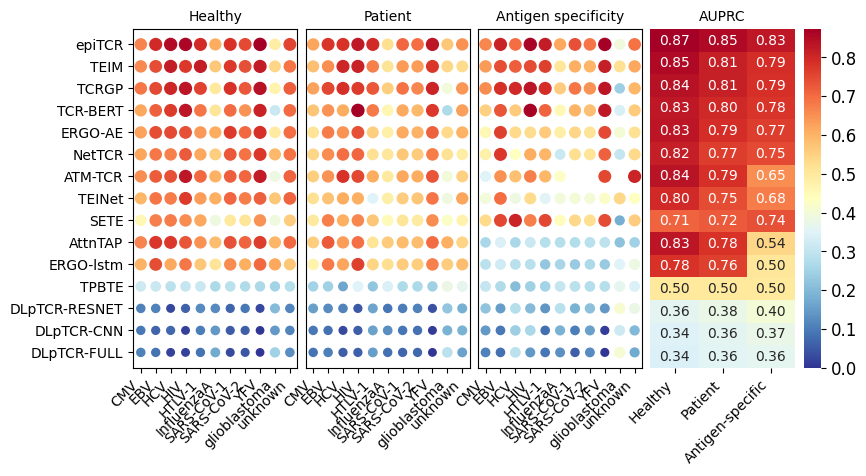

In [14]:
healthy=process_results('test/healthy/')
healthy.to_csv("./All_results/data/data2/C_seen_healthy_test.csv")
patient=process_results('test/patient/')
patient.to_csv("./All_results/data/data2/C_seen_patient_test.csv")
Antigen_specificity=process_results('test/Antigen_specificity/')
Antigen_specificity.to_csv("./All_results/data/data2/C_seen_Antigen_specificity_test.csv")
desired_index = healthy.index
patient = patient.reindex(index=desired_index)
Antigen_specificity = Antigen_specificity.reindex(index=desired_index)
all_data_test = pd.concat([healthy['AUPRC'], patient['AUPRC'], Antigen_specificity['AUPRC']], axis=1)
all_data_test.columns = ['Healthy', 'Patient', 'Antigen-specific']
all_data_test['Mean'] = all_data_test.mean(axis=1)
all_data_test = all_data_test.sort_values(by='Mean', ascending=False)
all_data_test = all_data_test.drop(columns=['Mean'])
generate_heatmap_and_scatterplots('test', all_data_test, "C_seen_three_negative_test")


# D

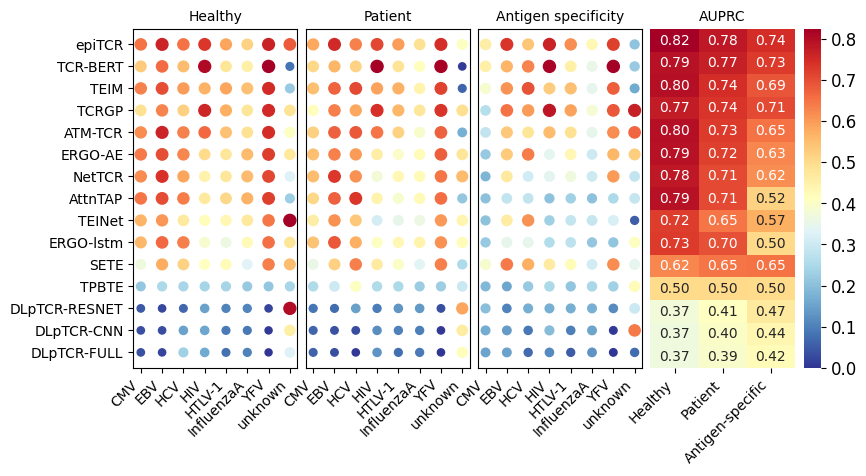

In [15]:
healthy=process_results('validation/healthy/')
healthy.to_csv("./All_results/data/data2/D_seen_healthy_validation.csv")
patient=process_results('validation/patient/')
patient.to_csv("./All_results/data/data2/D_seen_patient_validation.csv")
Antigen_specificity=process_results('validation/Antigen_specificity/')
Antigen_specificity.to_csv("./All_results/data/data2/D_seen_Antigen_specificity_validation.csv")
desired_index = healthy.index
patient = patient.reindex(index=desired_index)
Antigen_specificity = Antigen_specificity.reindex(index=desired_index)
all_data_test = pd.concat([healthy['AUPRC'], patient['AUPRC'], Antigen_specificity['AUPRC']], axis=1)
all_data_test.columns = ['Healthy', 'Patient', 'Antigen-specific']
all_data_test['Mean'] = all_data_test.mean(axis=1)
all_data_test = all_data_test.sort_values(by='Mean', ascending=False)
all_data_test = all_data_test.drop(columns=['Mean'])
generate_heatmap_and_scatterplots('validation', all_data_test, "D_seen_three_negative_validation")


# E

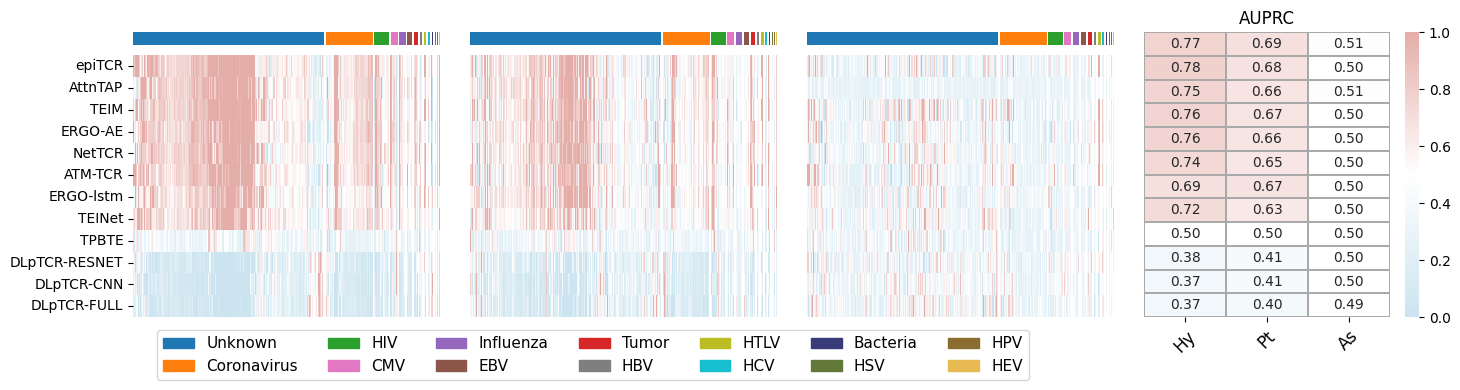

In [3]:
import pandas as pd
import numpy as np
import os

def read_data(Dean, ratio):
    name = ['1', '2', '3', '4', '5']
    dataframe_dict = {}
    merged_dict = {}
    for i in name:
        dataframe_dict['ERGO_AE'] = pd.read_csv(f"./ERGO/result/pair50/unseen/{Dean}/{i}_{ratio}ae_all_result.csv")
        dataframe_dict['ERGO_lstm'] = pd.read_csv(f"./ERGO/result/pair50/unseen/{Dean}/{i}_{ratio}lstm_all_result.csv")
        dataframe_dict['NetTCR'] = pd.read_csv(f"./NetTCR/result/pair50/unseen/{Dean}/{i}_{ratio}all_result.csv")
        dataframe_dict['DLpTCR_CNN'] = pd.read_csv(f"./DLpTCR/result/pair50/unseen/{Dean}/{i}_{ratio}CNN_pca20_all_result.csv")
        dataframe_dict['DLpTCR_FULL'] = pd.read_csv(f"./DLpTCR/result/pair50/unseen/{Dean}/{i}_{ratio}FULL_pca18_all_result.csv")
        dataframe_dict['DLpTCR_RESNET'] = pd.read_csv(f"./DLpTCR/result/pair50/unseen/{Dean}/{i}_{ratio}RESNET_pca10_all_result.csv")
        dataframe_dict['AttnTAP'] = pd.read_csv(f"./AttnTAP/result/pair50/unseen/{Dean}/{i}_{ratio}all_result.csv")
        dataframe_dict['ATM_TCR'] = pd.read_csv(f"./ATM_TCR/result/pair50/unseen/{Dean}/{i}_{ratio}all_result.csv")
        dataframe_dict['TEINet'] = pd.read_csv(f"./TEINet/result/pair50/unseen/{Dean}/{i}_{ratio}all_result.csv")
        dataframe_dict['epiTCR'] = pd.read_csv(f"./epiTCR/result/pair50/unseen/{Dean}/{i}_{ratio}all_result.csv")
        dataframe_dict['TEIM'] = pd.read_csv(f"./TEIM/result/pair50/unseen/{Dean}/{i}_{ratio}all_result.csv")
        dataframe_dict['TPBTE'] = pd.read_csv(f"./TPBTE/result/pair50/unseen/{Dean}/{i}_{ratio}all_result.csv")
        merged = pd.DataFrame()
        dataframe_names = ['ERGO_AE','ERGO_lstm','NetTCR', 'DLpTCR_CNN', 'DLpTCR_FULL', 'DLpTCR_RESNET', 'AttnTAP', 'ATM_TCR', 'TEINet', 'epiTCR', 'TEIM', 'TPBTE']

        for df_name in dataframe_names:
            df = dataframe_dict[df_name]
            last_row = df.tail(1)
            merged = pd.concat([merged, last_row])
        merged.set_index(pd.Index(dataframe_names), inplace=True)
        merged = merged.iloc[:, 1:]
        merged_dict[f'merged{i}'] = merged

    merged1, merged2, merged3, merged4, merged5 = (merged_dict[f'merged{i}'] for i in name)
    df_mean = (merged1 + merged2 + merged3 + merged4 + merged5) / 5
    new_column_names = {
        'roc_auc': 'AUROC', 'prc_auc': 'AUPRC', 'accuracy': 'Accuracy',
        'precision': 'Precision', 'recall': 'Recall', 'specificity': 'Specificity',
        'mcc': 'MCC', 'f1': 'F1'}
    df_mean.rename(columns=new_column_names, inplace=True)
    df_std = pd.concat([merged1, merged2, merged3, merged4, merged5]).groupby(level=0).std()
    new_column_names_std = {
        'roc_auc': 'AUROC_std', 'prc_auc': 'AUPRC_std', 'accuracy': 'Accuracy_std',
        'precision': 'Precision_std', 'recall': 'Recall_std', 'specificity': 'Specificity_std',
        'mcc': 'MCC_std', 'f1': 'F1_std'}
    df_std.rename(columns=new_column_names_std, inplace=True)

    df_mean = pd.concat([df_mean, df_std], axis=1)
    df_mean = df_mean.sort_values(by='AUPRC', ascending=False)
    df_mean.index = df_mean.index.str.replace('_', '-')
    new_column_order = [
        'AUROC', 'AUROC_std',
        'AUPRC', 'AUPRC_std',
        'Accuracy', 'Accuracy_std',
        'Precision', 'Precision_std',
        'Recall', 'Recall_std',
        'Specificity', 'Specificity_std',
        'MCC', 'MCC_std',
        'F1', 'F1_std'
    ]
    df_mean = df_mean[new_column_order]
    df_mean = df_mean.round(4)
    df_mean.rename_axis('models', inplace=True)
    
    name = ['1', '2', '3', '4', '5']
    mer_dict = {}
    for i in name:
        ERGO_AE = pd.read_csv(f"./ERGO/result/pair50/unseen/{Dean}/{i}_{ratio}ae_all_result.csv")
        ERGO_lstm = pd.read_csv(f"./ERGO/result/pair50/unseen/{Dean}/{i}_{ratio}lstm_all_result.csv")
        NetTCR = pd.read_csv(f"./NetTCR/result/pair50/unseen/{Dean}/{i}_{ratio}all_result.csv")
        DLpTCR_CNN = pd.read_csv(f"./DLpTCR/result/pair50/unseen/{Dean}/{i}_{ratio}CNN_pca20_all_result.csv")
        DLpTCR_FULL = pd.read_csv(f"./DLpTCR/result/pair50/unseen/{Dean}/{i}_{ratio}FULL_pca18_all_result.csv")
        DLpTCR_RESNET = pd.read_csv(f"./DLpTCR/result/pair50/unseen/{Dean}/{i}_{ratio}RESNET_pca10_all_result.csv")
        AttnTAP = pd.read_csv(f"./AttnTAP/result/pair50/unseen/{Dean}/{i}_{ratio}all_result.csv")
        ATM_TCR = pd.read_csv(f"./ATM_TCR/result/pair50/unseen/{Dean}/{i}_{ratio}all_result.csv")
        TEINet = pd.read_csv(f"./TEINet/result/pair50/unseen/{Dean}/{i}_{ratio}all_result.csv")
        epiTCR = pd.read_csv(f"./epiTCR/result/pair50/unseen/{Dean}/{i}_{ratio}all_result.csv")
        TEIM = pd.read_csv(f"./TEIM/result/pair50/unseen/{Dean}/{i}_{ratio}all_result.csv")
        TPBTE = pd.read_csv(f"./TPBTE/result/pair50/unseen/{Dean}/{i}_{ratio}all_result.csv")
        dataframes = {
            'ERGO_AE': ERGO_AE,
            'ERGO_lstm': ERGO_lstm,
            'NetTCR': NetTCR,
            'DLpTCR_CNN': DLpTCR_CNN,
            'DLpTCR_FULL': DLpTCR_FULL,
            'DLpTCR_RESNET': DLpTCR_RESNET,
            'AttnTAP': AttnTAP,
            'ATM_TCR': ATM_TCR,
            'TEINet': TEINet,
            'epiTCR': epiTCR,
            'TEIM': TEIM,
            'TPBTE': TPBTE}

        for model_name, df in dataframes.items():
            if model_name in mer_dict:
                mer_dict[model_name] = pd.concat([mer_dict[model_name], df])
            else:
                mer_dict[model_name] = df
    final_dataframes = {}
    for model_name, df in mer_dict.items():
        avg_df = df.groupby('epitope').mean().reset_index()
        avg_df = avg_df.drop(avg_df.index[-1])  
        avg_df = avg_df[['epitope', 'prc_auc']]
        avg_df = avg_df.rename(columns={'prc_auc': model_name})
        final_dataframes[model_name] = avg_df
    merged_df = None
    for model_name, df in final_dataframes.items():
        if merged_df is None:
            merged_df = df
        else:
            merged_df = pd.merge(merged_df, df, on='epitope', how='outer')
    merged_df = merged_df.set_index('epitope')
    merged_df = merged_df.T
    merged_df.rename(index=lambda x: x.replace('_', '-'), inplace=True)
    return merged_df, df_mean


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec
from scipy.cluster.hierarchy import linkage, leaves_list
import matplotlib.colors as mcolors

def plot_healthy_heatmap(merged_healthy, antigen_unique, bbox_to_anchor,ncol, num_gaps=3, figsize=(6, 3.5), ax=None):
    merged_with_species = pd.merge(merged_healthy.T, antigen_unique, on='epitope').set_index('epitope').T
    antigen_species = merged_with_species.iloc[-1, :]
    new_columns = [f"{antigen_species[i]}-{col}" for i, col in enumerate(merged_with_species.columns)]
    merged_with_species.columns = new_columns
    merged_with_species = merged_with_species.iloc[:-1, :]

    antigen_types = pd.Series([col.split('-')[0] for col in merged_with_species.columns], index=merged_with_species.columns)
    antigen_counts = antigen_types.value_counts()
    sorted_antigen_types = antigen_counts.index.tolist()
    sorted_df = pd.DataFrame()
    for antigen in sorted_antigen_types:
        cols_to_group = merged_with_species.loc[:, antigen_types == antigen]
        if cols_to_group.dropna(axis=1, how='all').shape[1] > 1:
            linkage_matrix = linkage(cols_to_group.T.dropna(), method='average')
            order = leaves_list(linkage_matrix)
            clustered_cols = cols_to_group.iloc[:, order]
        else:
            clustered_cols = cols_to_group
        sorted_df = pd.concat([sorted_df, clustered_cols], axis=1)
        for _ in range(num_gaps):
            gap_col = pd.DataFrame(np.nan, index=cols_to_group.index, columns=[f'gap_{antigen}'])
            sorted_df = pd.concat([sorted_df, gap_col], axis=1)
    sorted_df = sorted_df.iloc[:, :-num_gaps]
    df_rearranged = sorted_df
    epitope_order = df_rearranged.columns.tolist()
    epitope_order_df = pd.DataFrame(epitope_order, columns=['epitope_order'])
    epitope_order_df = epitope_order_df[~epitope_order_df['epitope_order'].str.contains('gap')]
    epitope_order_df.reset_index(drop=True, inplace=True)

    new_columns = [col.split('-')[0] for col in df_rearranged.columns]
    df_rearranged.columns = new_columns
    fixed_color_map = {
        'Unknown': '#1f77b4',    
        'Coronavirus': '#ff7f0e', 
        'HIV': '#2ca02c',        
        'CMV': '#e377c2',         
        'Influenza': '#9467bd',   
        'EBV': '#8c564b',        
        'Tumor': '#d62728',      
        'HBV': '#7f7f7f',        
        'HTLV': '#bcbd22',       
        'HCV': '#17becf',       
        'Bacteria': '#393b79',   
        'HSV': '#637939',        
        'HPV': '#8c6d31',        
        'HEV': '#e7ba52' }


    unique_columns = df_rearranged.columns.unique()
    unique_columns = [col for col in unique_columns if 'gap' not in col]
    col_colors = []
    for col in df_rearranged.columns:
        if not col.startswith('gap'):
            rgba_color = mcolors.to_rgba(fixed_color_map.get(col, (1.0, 1.0, 1.0))) 
            col_colors.append(rgba_color)
        else:
            col_colors.append((1.0, 1.0, 1.0, 1.0)) 
    
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_axes([0.1, 0.1, 0.6, 0.8])

    colors = ["#CCE4EF", "white", "#E5ADA8"]
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
    plt.rcParams['pdf.fonttype'] = 42
    sns.heatmap(df_rearranged.astype(float), cmap=cmap, cbar=False, ax=ax, xticklabels=False)

    divider = make_axes_locatable(ax)
    cax_above = divider.append_axes("top", size="5%", pad=0.1)
    cax_above.imshow([col_colors], aspect='auto', interpolation='nearest')
    cax_above.axis('off')
    handles = [Patch(color=fixed_color_map[key], label=key) for key in unique_columns if key in fixed_color_map]
    ax.legend(handles=handles, loc='upper center', bbox_to_anchor=bbox_to_anchor, borderaxespad=0.,
              fontsize=11, labelspacing=0.5, ncol=ncol)

    if ax is None:
        plt.show()
    return epitope_order_df


def plot_merged_heatmap(epitope_order_df, merged_patient, antigen_unique, figsize=(7, 3.5), ax=None, num_gaps=3):
    epitope_order_suffixes = epitope_order_df['epitope_order'].str.split('-', expand=True).iloc[:, -1]
    col_mapping = {col.split('-')[-1]: col for col in merged_patient.columns}
    sorted_columns = [col_mapping[suffix] for suffix in epitope_order_suffixes if suffix in col_mapping]

    merged_patient_sorted = merged_patient[sorted_columns]
    merged_with_species = pd.merge(merged_patient_sorted.T, antigen_unique, on='epitope').set_index('epitope').T
    antigen_species = merged_with_species.iloc[-1, :]
    new_columns = [f"{antigen_species[i]}-{col}" for i, col in enumerate(merged_with_species.columns)]
    merged_with_species.columns = new_columns
    merged_with_species = merged_with_species.iloc[:-1, :]
    antigen_types = pd.Series([col.split('-')[0] for col in merged_with_species.columns], index=merged_with_species.columns)
    antigen_counts = antigen_types.value_counts()
    sorted_antigen_types = antigen_counts.index.tolist()
    sorted_df = pd.DataFrame()
    for antigen in sorted_antigen_types:
        cols_to_group = merged_with_species.loc[:, antigen_types == antigen]
        clustered_cols = cols_to_group
        sorted_df = pd.concat([sorted_df, clustered_cols], axis=1)
        for _ in range(num_gaps):
            gap_col = pd.DataFrame(np.nan, index=cols_to_group.index, columns=[f'gap_{antigen}'])
            sorted_df = pd.concat([sorted_df, gap_col], axis=1)
    sorted_df = sorted_df.iloc[:, :-num_gaps]
    df_rearranged = sorted_df
    new_columns = [col.split('-')[0] for col in df_rearranged.columns]
    df_rearranged.columns = new_columns
    fixed_color_map = {
        'Unknown': '#1f77b4',    
        'Coronavirus': '#ff7f0e', 
        'HIV': '#2ca02c',        
        'CMV': '#e377c2',         
        'Influenza': '#9467bd',   
        'EBV': '#8c564b',        
        'Tumor': '#d62728',      
        'HBV': '#7f7f7f',        
        'HTLV': '#bcbd22',       
        'HCV': '#17becf',       
        'Bacteria': '#393b79',   
        'HSV': '#637939',        
        'HPV': '#8c6d31',        
        'HEV': '#e7ba52' }

    unique_columns = df_rearranged.columns.unique()
    unique_columns = [col for col in unique_columns if 'gap' not in col]

    col_colors = []
    for col in df_rearranged.columns:
        if not col.startswith('gap'):
            rgba_color = mcolors.to_rgba(fixed_color_map.get(col, (1.0, 1.0, 1.0)))  
            col_colors.append(rgba_color)
        else:
            col_colors.append((1.0, 1.0, 1.0, 1.0))  

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    colors = ["#CCE4EF", "white", "#E5ADA8"]
    plt.rcParams['pdf.fonttype'] = 42
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
    sns.heatmap(df_rearranged.astype(float), cmap=cmap, cbar=False, ax=ax, xticklabels=False, yticklabels=False)
    divider = make_axes_locatable(ax)
    cax_above = divider.append_axes("top", size="5%", pad=0.1)
    cax_above.imshow([col_colors], aspect='auto', interpolation='nearest')
    cax_above.axis('off')

    if ax is None:
        plt.show()


def plot_all_heatmap(all_mean_df, title='AUPRC', cmap_colors=None, figsize=(6, 4), ax=None):
    if cmap_colors is None:
        cmap_colors = ["#CCE4EF", "white", "#E5ADA8"]
    cmap = LinearSegmentedColormap.from_list("custom_cmap", cmap_colors)
    norm = Normalize(vmin=0, vmax=1)
    plt.rcParams['pdf.fonttype'] = 42
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(all_mean_df,annot=True, fmt=".2f", cmap=cmap,norm=norm,linewidths=0.2, linecolor='darkgray',ax=ax)
    ax.set_xticks(np.arange(all_mean_df.columns.size) + 0.5)
    ax.set_xticklabels(['Hy', 'Pt', 'As'], fontsize=12, rotation=45, ha='center', va='top')
    ax.set_yticks([])
    ax.set_title(title)
    ax.set_ylabel('')
    if ax is None:
        plt.show()
        
        
def combine_plots_in_row(merged_healthy, merged_patient, merged_Antigen_specificity, antigen_unique, all_mean_df,file_name_prefix,bbox_to_anchor,ncol):
    fig, axs = plt.subplots(1, 4, figsize=(17, 3.7)) 
    plt.subplots_adjust(wspace=0.1)
    plt.rcParams['pdf.fonttype'] = 42
    epitope_order_df = plot_healthy_heatmap(merged_healthy, antigen_unique,bbox_to_anchor=bbox_to_anchor,ncol=ncol, num_gaps=3, figsize=(6, 3.5), ax=axs[0])
    plot_merged_heatmap(epitope_order_df, merged_patient, antigen_unique, figsize=(7, 3.5), ax=axs[1])
    plot_merged_heatmap(epitope_order_df, merged_Antigen_specificity, antigen_unique, figsize=(7, 3.5), ax=axs[2])
    plot_all_heatmap(all_mean_df, title='AUPRC', cmap_colors=None, figsize=(3, 3.5), ax=axs[3])
    axs[3].set_aspect('auto')
    plt.savefig(f"./All_results/fig/fig3/{file_name_prefix}.pdf", bbox_inches='tight')
    plt.show()        

data=pd.read_csv("./raw_data/epitope_less_50.csv")
replace_dict = {
    'Influenza A virus': 'Influenza',
    'Influenza A virus (A/California/07/2009(H1N1))': 'Influenza',
    'Influenza A virus (A/Memphis/4/1973(H3N2)) (Influenza A virus (A/Memphis/4/73(H3N2)))': 'Influenza',
    'Influenza B virus (Influenza virus type B)': 'Influenza',
    'Homo sapiens (human)': 'Unknown',
    'HomoSapiens': 'Unknown',
    'nan': 'Unknown',
    'SARS-CoV2': 'Coronavirus',
    'SARS-CoV1': 'Coronavirus',
    'Acute myeloid leukaemia': 'Tumor',
    'Human herpesvirus 5 (Human cytomegalovirus)': 'CMV',
    'Human herpesvirus 4 (Epstein Barr virus)': 'EBV',
    'Human coronavirus NL63 (Coronavirus NL63)': 'Coronavirus',
    'H1N1 subtype (H1N1)': 'Influenza',
    'Hepatitis B virus (Human hepatitis B virus': 'HBV',
    'synthetic': 'Unknown',
    'Homo sapiens': 'Unknown',
    'Human immunodeficiency virus 1 (human immunodeficiency virus 1 HIV-1)': 'HIV',
    'Human immunodeficiency virus (HIV)': 'HIV',
    'Human immunodeficiency virus (HIV1)': 'HIV',
    'Hepatitis B virus (Human hepatitis B virus)': 'HBV',
    'HIV-1': 'HIV',
    'Human coronavirus 229E (Coronavirus 229E)': 'Coronavirus',
    'Hepatitis C virus': 'HCV',
    'Human papillomavirus type 16 (Human papilloma virus type 16)': 'HPV',
    'Merkel cell polyomavirus (MCPyV isolate R17b)': 'Tumor',
    'Human coronavirus HKU1 (isolate N1)': 'Coronavirus',
    'SARS coronavirus BJ01': 'Coronavirus',
    'Hepatitis E virus type 3 (Hepatitis E virus genotype 3)': 'HEV',
    'Human coronavirus OC43 (Human coronavirus (strain OC43))': 'Coronavirus',
    'Triticum aestivum (Canadian hard winter wheat)': 'Unknown',
    'SaccharomycesCerevisiae': 'Unknown',
    'Herpes simplex virus 2 (HSV2)': 'HSV',
    'Paslahepevirus balayani': 'Unknown',
    'Acidiphilium cryptum (Acidiphilum cryptum)': 'Unknown',
    'Human herpesvirus 1':  'HSV',
    'Mycobacterium tuberculosis': 'Bacteria',
    'HIV1': 'HIV',
    'Middle East respiratory syndrome-related coronavirus (MERS coronavirus)': 'Coronavirus',
    'Bacteroides stercoris':'Bacteria',
    'melanoma':'Tumor',
    'lung_cancer':'Tumor',
    'SARS-CoV-2':'Coronavirus',
    'InfluenzaA':'Influenza',
    'HSV-2':'HSV' ,
    'MCPyV':'Tumor', 
    'M.tuberculosis': 'Bacteria',
'HTLV-1':'HTLV'}

data['antigen_species'] = data['antigen_species'].astype(str)
data['antigen_species'] = data['antigen_species'].replace(replace_dict)
data['antigen_species'].fillna('Unknown', inplace=True)
data.to_csv("./All_results/data/data2/unseen_test_antigen.csv")
pd.unique(data['antigen_species'])
data=data[['Epitope','antigen_species']]
data = data.rename(columns={'Epitope': 'epitope'})
epitope_counts = data.groupby('antigen_species')['epitope'].nunique()
antigen_unique = data.drop_duplicates(subset=['epitope', 'antigen_species'])

merged_healthy, mean_healthy = read_data('test/healthy', '1_1')
merged_patient, mean_patient= read_data('test/patient', '1_1')
merged_Antigen_specificity, mean_Antigen_specificity = read_data('test/Antigen_specificity', '1_1')

mean_healthy.to_csv("./All_results/data/data2/E_unseen_healthy_test.csv")
mean_patient.to_csv("./All_results/data/data2/E_unseen_patient_test.csv")
mean_Antigen_specificity.to_csv("./All_results/data/data2/E_unseen_Antigen_specificity_test.csv")
dataframes = [mean_healthy['AUPRC'], mean_patient['AUPRC'], mean_Antigen_specificity['AUPRC']]

all_mean_df = pd.concat(dataframes, axis=1, join='inner')
all_mean_df['Mean'] = all_mean_df.mean(axis=1)
all_mean_df = all_mean_df.sort_values(by='Mean', ascending=False)
all_mean_df = all_mean_df.drop(columns=['Mean'])

merged_healthy = merged_healthy.reindex(all_mean_df.index)
merged_patient = merged_patient.reindex(all_mean_df.index)
merged_Antigen_specificity = merged_Antigen_specificity.reindex(all_mean_df.index)
combine_plots_in_row(merged_healthy, merged_patient, merged_Antigen_specificity, antigen_unique, all_mean_df,'E_unseen_three_negative_test',(1.5, -0.05),7)    
    

# F

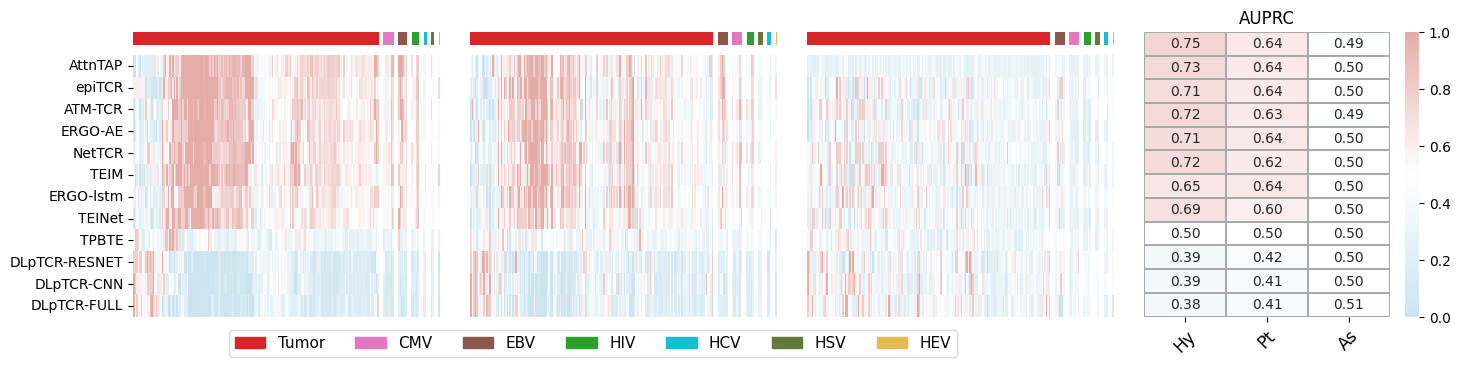

In [4]:
import pandas as pd
import os
new_path = "/home/luyanping/data/TCR_epitope_prediction/Compare_models_same_data/"
os.chdir(new_path)
data=pd.read_csv("./database/benchmark_dataset/raw_data/unkown_validaiton.csv")
replace_dict = {
    'Melanoma': 'Tumor',
    'Epstein Barr virus (EBV)': 'EBV',
    'Herpes simplex virus 2 (HSV2)': 'HSV',
    'Hepatitis C virus': 'HCV',
    'Human immunodeficiency virus (HIV)': 'HIV',
    'Cytomegalovirus (CMV)': 'CMV',
    'Acute myeloid leukemia': 'Tumor',
    'Neoantigen': 'Tumor',
    'Hepatitis C virus (HCV)': 'HCV',
    'Human herpes virus 1': 'HSV',
    'Hepatitis E virus infection (cHEV)': 'HEV',
    'Tumor associated antigen (TAA)': 'Tumor'}

data['antigen_species'] = data['antigen_species'].replace(replace_dict)
pd.unique(data['antigen_species'])

data['antigen_species'].value_counts()
data=data[['Epitope','antigen_species']]
data = data.rename(columns={'Epitope': 'epitope'})
data.to_csv("./All_results/data/data2/unseen_validation_raw_data.csv")
epitope_counts = data.groupby('antigen_species')['epitope'].nunique()
antigen_unique = data.drop_duplicates(subset=['epitope', 'antigen_species'])

merged_healthy, mean_healthy = read_data('validation/healthy', '1_1')
merged_patient, mean_patient= read_data('validation/patient', '1_1')
merged_Antigen_specificity, mean_Antigen_specificity = read_data('validation/Antigen_specificity', '1_1')

mean_healthy.to_csv("./All_results/data/data2/F_unseen_healthy_validation.csv")
mean_patient.to_csv("./All_results/data/data2/F_unseen_patient_validation.csv")
mean_Antigen_specificity.to_csv("./All_results/data/data2/F_unseen_Antigen_specificity_validation.csv")
dataframes = [mean_healthy['AUPRC'], mean_patient['AUPRC'], mean_Antigen_specificity['AUPRC']]

all_mean_df = pd.concat(dataframes, axis=1, join='inner')
all_mean_df['Mean'] = all_mean_df.mean(axis=1)
all_mean_df = all_mean_df.sort_values(by='Mean', ascending=False)
all_mean_df = all_mean_df.drop(columns=['Mean'])

merged_healthy = merged_healthy.reindex(all_mean_df.index)
merged_patient = merged_patient.reindex(all_mean_df.index)
merged_Antigen_specificity = merged_Antigen_specificity.reindex(all_mean_df.index)
combine_plots_in_row(merged_healthy, merged_patient, merged_Antigen_specificity, antigen_unique, all_mean_df,'F_unseen_three_negative_validation',(1.5, -0.05),7)    
    